# 8.1.Average_Models_MobileNetV2

In [ ]:
#!pip install sklearn
#!pip install imutils

In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: all CUDA-capable devices are busy or unavailable

# Recuperamos los modelos

In [3]:
img_size = 224
input_shape = (img_size, img_size, 3)
path_checkpoints = 'checkpoint_MobileNetV2/'

classNames = ['10', '100', '20', '200', '50']
classNames_ids = [0,1,2,3,4]

In [4]:
from tensorflow.keras.applications import MobileNetV2

In [5]:
checkpoint_1 = 'epoch-045-val_loss:0.0212-val_accuracy:0.9933.hdf5'
model_1 = MobileNetV2(include_top=True,
                    weights=None,
                    input_shape=input_shape,
                    classes=len(classNames_ids),
                    classifier_activation='softmax'
                   )
model_1.load_weights(path_checkpoints + checkpoint_1)

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [15]:
checkpoint_2 = 'epoch-746-val_loss:0.1489-val_accuracy:0.9521.hdf5'
model_2 = MobileNetV2(include_top=True,
                    weights=None,
                    input_shape=input_shape,
                    classes=len(classNames_ids),
                    classifier_activation='softmax'
                   )
model_2.load_weights(path_checkpoints + checkpoint_2)

In [16]:
checkpoint_3 = 'epoch-2947-val_loss:0.1408-val_accuracy:0.9643.hdf5'
model_3 = MobileNetV2(include_top=True,
                    weights=None,
                    input_shape=input_shape,
                    classes=len(classNames_ids),
                    classifier_activation='softmax'
                   )
model_3.load_weights(path_checkpoints + checkpoint_3)

# Realizando el ensamblado

In [18]:
models = [model_1, model_2, model_3]

# Verificando la predicción promedio

In [30]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from pyimagesearch.preprocessing import ImageToArrayPreprocessor
from pyimagesearch.datasets import SimpleDatasetLoader
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np

In [24]:
path_validation = 'data_' + str(img_size) + '/validation'
imagePaths_validation = list(paths.list_images(path_validation))

iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessors=[iap])

print('Cargando data para la validación')
data_validation, labels_validation = sdl.load(imagePaths_validation, verbose=500)

print('Binarizando los labels')
labels_validation = LabelBinarizer().fit_transform(labels_validation)

print('Carga terminada')


Cargando data para la validación
[INFO] processed 500/2671
[INFO] processed 1000/2671
[INFO] processed 1500/2671
[INFO] processed 2000/2671
[INFO] processed 2500/2671
Binarizando los labels
Carga terminada


In [25]:
data_validation = data_validation / 255

In [31]:
print('[INFO] Evaluando el ensamblado')
predictions = []

for model in models:
    predictions.append(model.predict(data_validation))

predictions = np.average(predictions, axis=0)
print(classification_report(labels_validation.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=classNames))

[INFO] Evaluando el ensamblado
              precision    recall  f1-score   support

          10       1.00      0.51      0.67       477
         100       0.52      0.86      0.65       584
          20       0.97      0.16      0.28       485
         200       0.49      0.90      0.63       583
          50       1.00      0.57      0.72       542

    accuracy                           0.62      2671
   macro avg       0.80      0.60      0.59      2671
weighted avg       0.78      0.62      0.60      2671



In [33]:
print('[INFO] Evaluando un modelo')

predictions = []
predictions = model_3.predict(data_validation)

print(classification_report(labels_validation.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=classNames))

[INFO] Evaluando un modelo
              precision    recall  f1-score   support

          10       1.00      0.41      0.58       477
         100       0.52      0.82      0.63       584
          20       0.97      0.14      0.24       485
         200       0.46      0.93      0.62       583
          50       1.00      0.57      0.73       542

    accuracy                           0.60      2671
   macro avg       0.79      0.57      0.56      2671
weighted avg       0.77      0.60      0.57      2671



# Tomando 25 imágenes de validación y observando el resultado

In [34]:
from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader

import matplotlib.pyplot as plt

In [86]:
models = [model_1, model_2, model_3]
#models = [model_3]

INFO:tensorflow:Load image with size: 2671, num_label: 5, labels: 10, 100, 20, 200, 50.


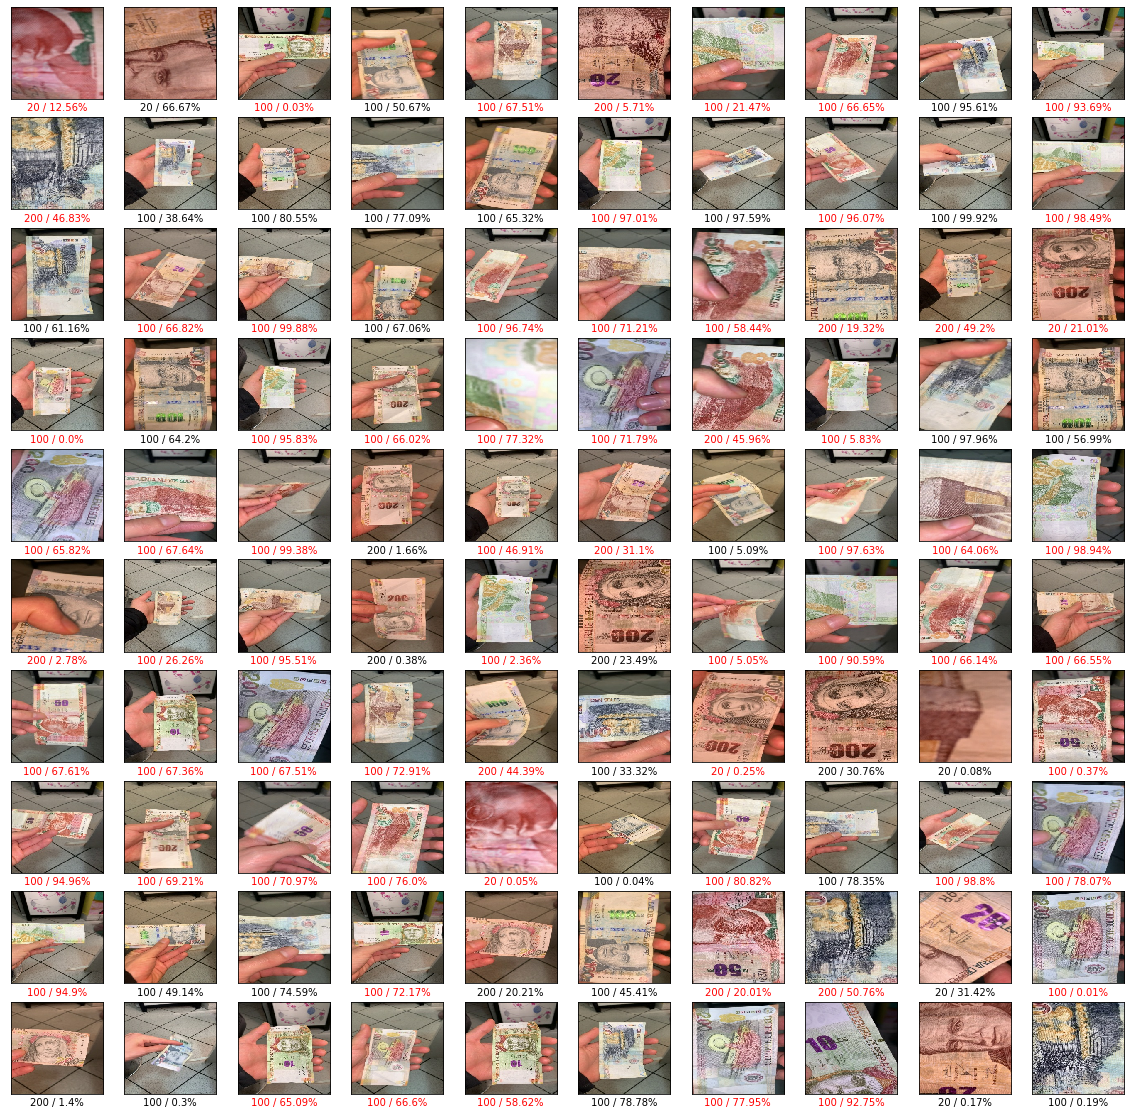

In [87]:
test_data = ImageClassifierDataLoader.from_folder(path_validation)

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)

    #predict
    swapped = np.moveaxis(image, 0, 1)
    arr4d = np.expand_dims(swapped, 0)
    
    #utilizando el average de los modelos para la predicción
    predictions = []
    #counter = 0
    for model in models:
        #if counter == 0:
        #    print('==========')
        #if counter > 2:
        #    counter = 0
        #print(np.argmax(model.predict(arr4d)))
        #print(classNames[np.argmax(model.predict(arr4d))])
        predictions.append(model.predict(arr4d))
        #counter += 1
    #print(predictions)
    #print('==')
    prediction_average = np.average(predictions, axis=0)
    percentage = round(prediction_average[0][id_predict] * 100, 2)
    id_predict = np.argmax(prediction_average)
    predict_label = classNames[id_predict]
    
    #print(prediction_average * 100)
    #print(id_predict)
    #print('==============')
    
    #setup color
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    ax.xaxis.label.set_color(color)
    image_label = predict_label + ' / ' + str(percentage) + '%'
    plt.xlabel(image_label)
plt.show()